In [36]:
%pylab inline
import gc
import galsim
import numpy as np
import fpfsBase
import astropy.io.fits as pyfits

import fpfsBase

def measure(galImgAll,C):
    imgList=[galImgAll[i//nx*ngrid+beg:i//nx*ngrid+end,i%nx*ngrid+beg:i%nx*ngrid+end] for i in range(ngal)]
    a=fpTask.measure(imgList)
    b=fpfsBase.fpfsM2E(a,C)
    del imgList,a
    gc.collect()
    return b

def main(elli0,slow=0.,shigh=1.1):
    dss=0.01
    elli=elli0.copy()
    mask=(elli['fpfs_s0']>slow)&(elli['fpfs_s0']<shigh)
    elli=elli[mask]
    mask2=elli['fpfs_s0']<slow+dss
    RS2=-np.sqrt(2.)*np.sum((1-elli[mask2]['fpfs_s0'])*elli[mask2]['fpfs_e1']**2./dss)
    mask3=elli['fpfs_s0']>shigh-dss
    RS3=np.sqrt(2.)*np.sum((1-elli[mask3]['fpfs_s0'])*elli[mask3]['fpfs_e1']**2./dss)
    RS=RS2+RS3
    g1=np.sum(elli['fpfs_e1'])/(np.sum(elli['fpfs_RE'])+RS)
    del mask,elli,mask2,RS
    gc.collect()
    return g1

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd wrkDir/FPFS2/sim

/lustre/work/xiangchong.li/work/FPFS2/sim


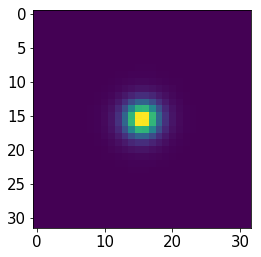

In [10]:
ngrid=64
nx=100;ny=100
ngal=nx*ny
scale=0.168
beta=0.75
psfFWHM=0.60
rcut=16
beg=ngrid//2-rcut
end=beg+2*rcut
# Initialize the fpfsTask
psfInt  =   galsim.Moffat(beta=3.5,fwhm=psfFWHM,trunc=psfFWHM*4.)
psfInt  =   psfInt.shear(e1=0.02,e2=-0.02)
psfImg  =   psfInt.drawImage(nx=64,ny=64,scale=scale)
psfData =   psfImg.array[beg:end,beg:end]
plt.imshow(psfData)
fpTask=fpfsBase.fpfsTask(psfData,beta=beta)
# read galaxy image
galImgAll1=pyfits.getdata('galaxy_basic_psf%d/image-0-g1-2222.fits' %(psfFWHM*100))
galImgAll2=pyfits.getdata('galaxy_basic_psf%d/image-0-g1-0000.fits' %(psfFWHM*100))

0.1978466933819921


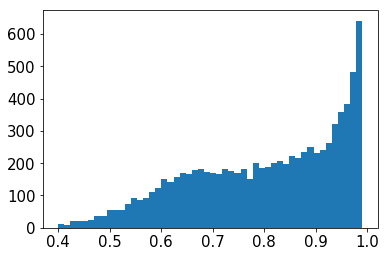

In [25]:
C=100

elli1=measure(galImgAll1,C)
elli2=measure(galImgAll2,C)

plt.hist(elli1['fpfs_s0'],bins=50,range=(0.4,0.99))
print(elli1['fpfs_s0'].min())

In [37]:
gest=[]
slowList=np.linspace(0.4,0.8,5)

for slow in slowList:
    g1p=main(elli1,slow,1.1)
    g1m=main(elli2,slow,1.1)
    gest.append(g1m-g1p)
    gc.collect
    print(np.average(gest)/0.04-1)

0.0002553474204758377
0.0008728428202371408
0.0018711678381304608
0.0007157190027877736
-9.74955109802611e-05


In [38]:
slowList=np.linspace(0.6,1.0,5)
for shigh in slowList:
    g1p=main(elli1,0.,shigh)
    g1m=main(elli2,0.,shigh)
    gest.append(g1m-g1p)
    gc.collect
    print(np.average(gest)/0.04-1)

-0.003665774392888621
-0.0005674968680174919
0.0008135113257581317
0.0027760722729899268
0.002242860762491361
